In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
!unzip drive/MyDrive/PhC-C2DH-U373.zip

Archive:  drive/MyDrive/PhC-C2DH-U373.zip
replace PhC-C2DH-U373/01/t000.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [12]:
from matplotlib import pyplot as plt
import numpy as np
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import metrics
from tensorflow.keras import backend as K

In [13]:
from PIL import Image

# Cargo Train y Val

Train será aumentado

In [14]:
train_path = Path("PhC-C2DH-U373/01/").glob("**/*tif")
val_path = Path("PhC-C2DH-U373/02/").glob("**/*tif")

In [15]:
train_images = list()
train_masks = list()
for file in train_path:
    train_images.append(np.array(Image.open(file)).reshape(1,520,696))
    train_masks.append(np.array(Image.open(f'PhC-C2DH-U373/01_ST/SEG/man_seg{file.name[1:]}')).reshape(1,520,696))

val_images = list()
val_masks = list()

for file in val_path:
    val_images.append(np.array(Image.open(file)).reshape(1,520,696))
    val_masks.append(np.array(Image.open(f'PhC-C2DH-U373/02_ST/SEG/man_seg{file.name[1:]}')).reshape(1,520,696))

In [16]:
train_images = np.vstack(train_images)/255
train_masks = 1*(np.vstack(train_masks) > 0)
val_images = np.vstack(val_images)/255
val_masks = 1*(np.vstack(val_masks) >0 )

# Imágenes de train sin aumentar

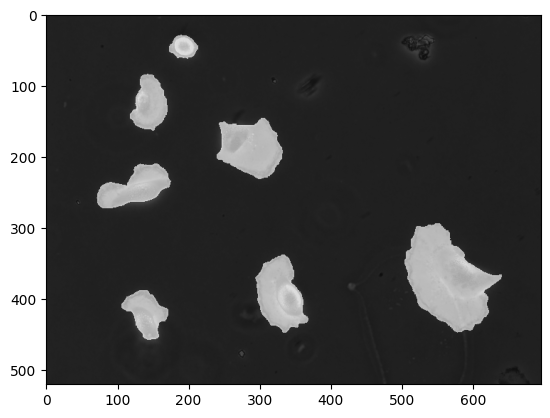

In [17]:
idx = 100
plt.imshow(train_images[idx], vmin=0, vmax=1, cmap="gray")
plt.imshow(train_masks[idx], vmin=0, vmax=1, cmap="gray",alpha=0.6)
plt.show()

# Armo datasets de tensorflow y aumento

Para mantener sincronizada la aumentación entre la imagen y la máscara, armo una entrada de 4 canales que de descompondrán durante el entrenamiento.

In [18]:
x_train = np.stack((train_images, train_masks ),axis=-1)
x_val = np.stack((val_images, val_masks ),axis=-1)

In [19]:
x_train[0,:,:,0].max()

0.7254901960784313

In [20]:
len(x_train)

115

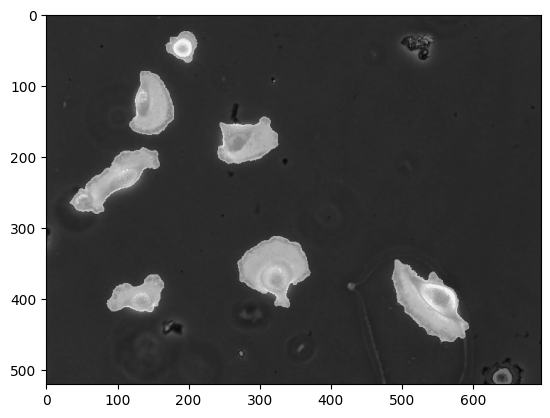

In [21]:
plt.imshow(x_train[0,:,:,0], cmap="gray")
plt.imshow(x_train[0,:,:,1], cmap="gray", alpha = 0.5)

In [22]:
from tensorflow.keras.models import Sequential

# Armo una red mínima fully convolutional con Atrous Convolutions

In [23]:
filters = 16
kernel_size = 10
def get_red_seg():
    return Sequential([
        tf.keras.layers.Conv2D(filters, kernel_size,padding="same", activation = "relu", dilation_rate = 1, input_shape = (None,None,1)),
        tf.keras.layers.Conv2D(filters, kernel_size,padding="same", activation = "relu", dilation_rate = 2),
        tf.keras.layers.Conv2D(filters, kernel_size,padding="same", activation = "relu", dilation_rate = 4),
        tf.keras.layers.Conv2D(filters, kernel_size,padding="same", activation = "relu", dilation_rate = 8),
        tf.keras.layers.Conv2D(filters, kernel_size,padding="same", activation = "relu", dilation_rate = 1),
        tf.keras.layers.Conv2D(1, kernel_size,padding="same", activation = "sigmoid", dilation_rate = 1)
    ])


# Armo la red de preprocesamiento para hacer aumentación en la GPU que no tengo

In [24]:
def get_preproc():
    return Sequential([
        tf.keras.layers.RandomCrop(512,512),
        tf.keras.layers.RandomFlip(mode='horizontal_and_vertical'),
        #tf.keras.layers.RandomZoom((-0.1,0.3)),
        #tf.keras.layers.RandomTranslation((-0.5, 0.5), (-0.5,0.5)),
        #tf.keras.layers.RandomRotation((0,1)),
        #tf.keras.layers.RandomZoom((0.5,0.5)),
        ])

def get_preproc_val():
    return Sequential([
        tf.keras.layers.CenterCrop(512,512),
        ])

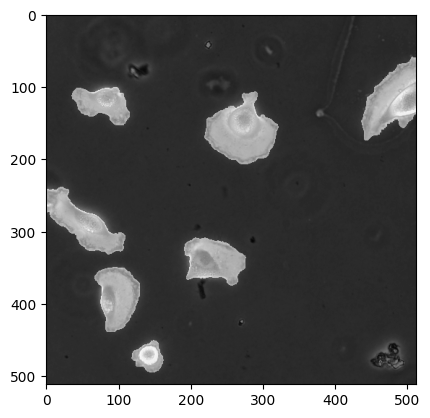

In [25]:
preproc = get_preproc()
aux_elem = preproc(x_train[0])
plt.imshow(aux_elem[:,:,0], cmap="gray")
plt.imshow(aux_elem[:,:,1], cmap="gray", alpha = 0.5)

In [26]:
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

def dice_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [27]:
class SegmentationModel(Model):
    def __init__(self, red_preproc, red_segmentacion, red_preproc_val):
        super().__init__()
        self.red_segmentacion = red_segmentacion
        self.red_preproc = red_preproc
        self.red_preproc_val = red_preproc_val
        self.loss_tracker = metrics.Mean(name="loss")
        self.dice = False


    def call(self, inputs):
        #img_mask = self.red_preproc = red_preproc(inputs)
        return self.red_segmentacion(inputs[:,:,:1])

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            data_aug = self.red_preproc(data)
            loss = self._compute_loss(data_aug)
            #print(K.mean(loss))

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.red_segmentacion.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.red_segmentacion.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        data_preproc = self.red_preproc_val(data)
        loss = self._compute_loss(data_preproc)
        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        #aux = self.red_preproc(data)
        mask_out = self.red_segmentacion(data[:,:,:,:1])
        #print(mask_out.shape)
        #print(data[:,:,:,1:2].numpy())
        if self.dice == True:
            loss = dice_loss(data[:,:,:,1:2], mask_out)
        else:
            loss = tf.keras.losses.binary_crossentropy(data[:,:,:,1:2], mask_out)
        return loss

    # property
    # def metrics(self):
    #     # We need to list our metrics here so the `reset_states()` can be
    #     # called automatically.
    #     return [self.loss_tracker]

In [28]:
red_falopa = get_red_seg()

In [29]:
red_falopa.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, None, None, 16)    1616      
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 16)    25616     
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 16)    25616     
                                                                 
 conv2d_3 (Conv2D)           (None, None, None, 16)    25616     
                                                                 
 conv2d_4 (Conv2D)           (None, None, None, 16)    25616     
                                                                 
 conv2d_5 (Conv2D)           (None, None, None, 1)     1601      
                                                                 
Total params: 105,681
Trainable params: 105,681
Non-tr

In [30]:
preproc= get_preproc()
preproc_val = get_preproc_val()
red_falopa = get_red_seg()
model = SegmentationModel(preproc, red_falopa,preproc_val)

In [31]:
model.compile(optimizer= tf.keras.optimizers.Adam(1e-4))

In [32]:
len(x_val)

115

In [33]:
model.fit(np.vstack([x_train, x_val]),batch_size=16, epochs=100, validation_split = 0.5, verbose = 1)

Epoch 1/100
8/8 [==============================] - 78s 2s/step - loss: 0.6764 - val_loss: 0.6082
Epoch 2/100
8/8 [==============================] - 8s 1s/step - loss: 0.5274 - val_loss: 0.2444
Epoch 3/100
8/8 [==============================] - 8s 1s/step - loss: 0.3606 - val_loss: 0.1751
Epoch 4/100
8/8 [==============================] - 9s 1s/step - loss: 0.3444 - val_loss: 0.2413
Epoch 5/100
8/8 [==============================] - 8s 1s/step - loss: 0.3344 - val_loss: 0.1848
Epoch 6/100
8/8 [==============================] - 8s 1s/step - loss: 0.3376 - val_loss: 0.2132
Epoch 7/100
8/8 [==============================] - 8s 1s/step - loss: 0.3320 - val_loss: 0.1877
Epoch 8/100
8/8 [==============================] - 8s 1s/step - loss: 0.3316 - val_loss: 0.2054
Epoch 9/100
8/8 [==============================] - 8s 1s/step - loss: 0.3247 - val_loss: 0.1869
Epoch 10/100
8/8 [==============================] - 8s 1s/step - loss: 0.3196 - val_loss: 0.1909
Epoch 11/100
8/8 [====================

In [34]:
pred = red_falopa(x_val[0:1,:,:,0])
pred.shape

TensorShape([1, 520, 696, 1])

In [35]:
pred.numpy().max()

0.99709654

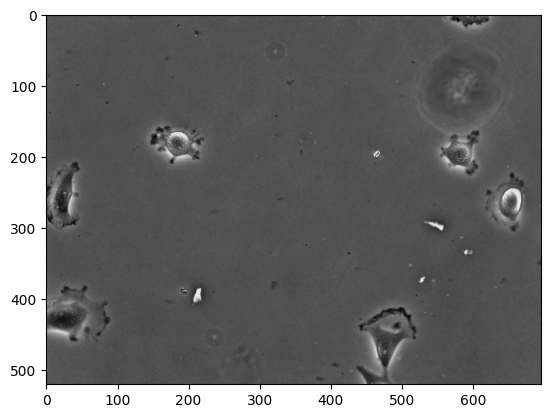

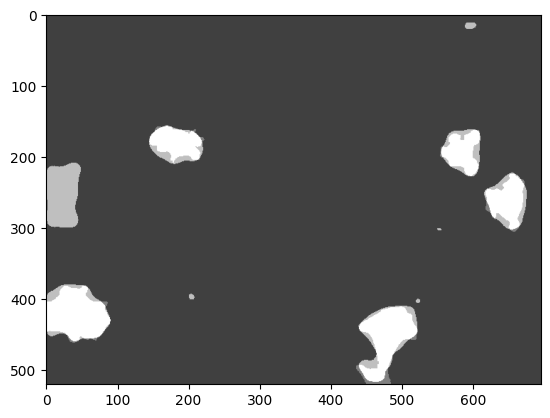

In [36]:
plt.imshow(x_val[0,:,:,0], cmap="gray")
plt.show()
plt.imshow(x_val[0,:,:,1], cmap="gray", alpha=0.5)
plt.imshow(pred[0,:,:,0]>0.5, cmap="gray", alpha=0.5)
plt.show()

In [37]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dropout, Concatenate, MaxPooling2D, UpSampling2D,Conv2DTranspose

In [38]:
img_shape = (512, 512, 1)
def conv_block(m, dim, acti, bn, res, do=0):
	n = Conv2D(dim, 3, activation=acti, padding='same')(m)
	n = BatchNormalization()(n) if bn else n
	n = Dropout(do)(n) if do else n
	n = Conv2D(dim, 3, activation=acti, padding='same')(n)
	n = BatchNormalization()(n) if bn else n
	return Concatenate()([m, n]) if res else n

def level_block(m, dim, depth, inc, acti, do, bn, mp, up, res):
	if depth > 0:
		n = conv_block(m, dim, acti, bn, res)
		m = MaxPooling2D()(n) if mp else Conv2D(dim, 3, strides=2, padding='same')(n)
		m = level_block(m, int(inc*dim), depth-1, inc, acti, do, bn, mp, up, res)
		if up:
			m = UpSampling2D()(m)
			m = Conv2D(dim, 2, activation=acti, padding='same')(m)
		else:
			m = Conv2DTranspose(dim, 3, strides=2, activation=acti, padding='same')(m)
		n = Concatenate()([n, m])
		m = conv_block(n, dim, acti, bn, res)
	else:
		m = conv_block(m, dim, acti, bn, res, do)
	return m

def UNet(img_shape, out_ch=1, start_ch=64, depth=4, inc_rate=2., activation='relu',
		 dropout=0.5, batchnorm=False, maxpool=True, upconv=True, residual=False):
	i = Input(shape=img_shape)
	o = level_block(i, start_ch, depth, inc_rate, activation, dropout, batchnorm, maxpool, upconv, residual)
	o = Conv2D(out_ch, 1, activation='sigmoid')(o)
	return Model(inputs=i, outputs=o)

In [39]:
preproc_unet= get_preproc()
preproc_unet_val= get_preproc_val()
red_unet = UNet(
    img_shape,
    start_ch = 16,
    dropout = False,
    residual = True
)
model_unet = SegmentationModel(preproc_unet, red_unet,preproc_unet_val)

In [40]:
model_unet.compile(optimizer= tf.keras.optimizers.Adam(1e-4))

In [41]:
model_unet.fit(np.vstack([x_train, x_val]),batch_size=16, epochs=100, validation_split = 0.5, verbose = 1)

Epoch 1/100
8/8 [==============================] - 51s 3s/step - loss: 0.6631 - val_loss: 0.5903
Epoch 2/100
8/8 [==============================] - 12s 1s/step - loss: 0.5280 - val_loss: 0.2713
Epoch 3/100
8/8 [==============================] - 12s 1s/step - loss: 0.3802 - val_loss: 0.2199
Epoch 4/100
8/8 [==============================] - 12s 1s/step - loss: 0.3575 - val_loss: 0.2314
Epoch 5/100
8/8 [==============================] - 12s 1s/step - loss: 0.3509 - val_loss: 0.2121
Epoch 6/100
8/8 [==============================] - 14s 2s/step - loss: 0.3449 - val_loss: 0.2069
Epoch 7/100
8/8 [==============================] - 12s 1s/step - loss: 0.3380 - val_loss: 0.2081
Epoch 8/100
8/8 [==============================] - 12s 1s/step - loss: 0.3356 - val_loss: 0.1970
Epoch 9/100
8/8 [==============================] - 12s 1s/step - loss: 0.3275 - val_loss: 0.1995
Epoch 10/100
8/8 [==============================] - 12s 1s/step - loss: 0.3091 - val_loss: 0.1740
Epoch 11/100
8/8 [===========

In [42]:
red_unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_12 (Conv2D)             (None, 512, 512, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_13 (Conv2D)             (None, 512, 512, 16  2320        ['conv2d_12[0][0]']              
                                )                                                             

In [43]:
aux = preproc_unet_val(x_val[0:1,:,:,:])
pred = red_unet(aux[0:1,:,:,0])
pred.shape

TensorShape([1, 512, 512, 1])

In [44]:
pred.numpy().max()

0.9986314

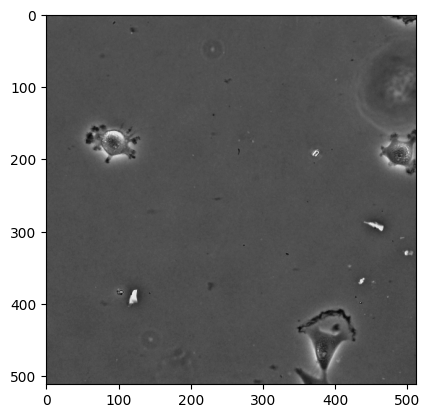

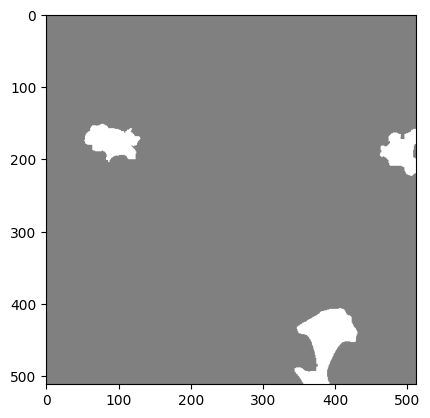

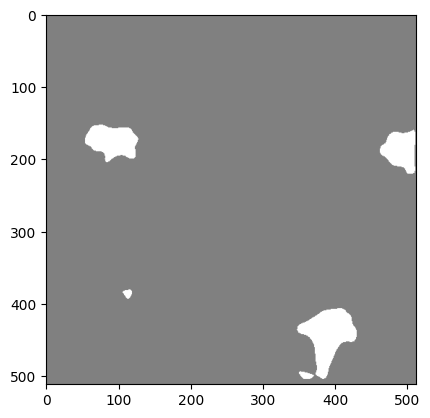

In [45]:
plt.imshow(aux[0,:,:,0], cmap="gray")
plt.show()
plt.imshow(aux[0,:,:,1], cmap="gray", alpha = 0.5)
plt.show()
plt.imshow(pred[0,:,:,0]>0.7, cmap="gray", alpha = 0.5)
plt.show()

In [45]:
y_pr